# Drifters trajectories (idealized simulation) : Compute the correlation function from the drifters outputs of the simulation

The correlation is computed along the trajectory of each drifter. We then average over bins (squares) using data of all drifters.\
To compute the correlation for each drifters, we divide the velocity time series in segments of the wanted time window size (T) overlapping by 50%. The correlation is computed over each segments and results for each segments are then combined.

In [1]:
import os
from glob import glob
import threading

import numpy as np
import dask.dataframe as dd
from dask import delayed
import pandas as pd
import xarray as xr

%matplotlib inline
from matplotlib import pyplot as plt
#import matplotlib.animation as anima

import crocosi.postp as pp
from crocosi.jet import set_relevant_time
import phdequinox.croco_drifter as cdr
import scipy.interpolate as interpolate


In [2]:
from dask.distributed import Client, LocalCluster
#cluster = LocalCluster()
from dask_jobqueue import PBSCluster
cluster = PBSCluster()
w = cluster.scale(jobs=6)

In [3]:
from dask.distributed import Client
#client = Client()  # set up local cluster on your laptop
client = Client(cluster) # with distributed cluster

In [4]:
client

Client Scheduler: tcp://10.148.0.249:60169 Dashboard: http://10.148.0.249:8787/status,Cluster Workers: 42 Cores: 42 Memory: 719.88 GB


In [4]:
root_path = '/home/datawork-lops-osi/equinox/jetn/'#old/'
#root_path = '/home1/datawork/slgentil/'#jet_cfg1_wp75_4km_1500a2000j_floats_lev50
run = 'jet_cfg1_wp8_m1a1_4km_500a1000j/'#'jet_cfg1_wp75_4km_1500a2000j_itide/'

### Load eulerian field average

In [5]:
eulerian_field = xr.open_dataset(root_path+run+'diagnostics/ZC_Eulerian_field.nc').persist()

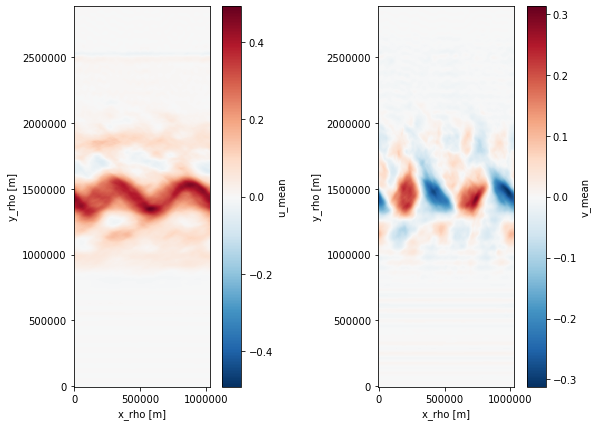

In [6]:
fig,axs = plt.subplots(1,2,figsize=(10,7))
for V,ax in zip(['u_mean','v_mean'],axs):
    eulerian_field[V].plot(ax=ax)
    ax.set_aspect('equal')

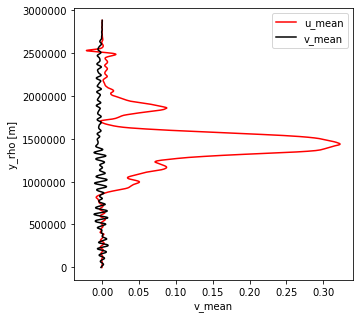

In [7]:
#Zonal :
fig,ax = plt.subplots(figsize=(5,5))
for V,c in zip(['u_mean','v_mean'],['r','k']):
    eulerian_field[V].mean('x_rho').plot(y='y_rho',c=c,ax=ax,label=V)
    
ax.legend()

In [8]:
#write parquet
dr.store_parquet(index='id')

### Load drifters trajectories

In [8]:
dr = cdr.drifter_dataframe(root_path+run,parquet=True,index='id',persist=False)
dr

         time      xgrid      ygrid  zgrid     depth       temp         u  \
id                                                                          
1   514.86806  15.308000  140.24689   50.0  0.567729  24.579610 -0.039899   
1   508.40278  12.586232  143.23956   50.0  0.582854  24.579541 -0.057364   
1   508.39583  12.594833  143.24356   50.0  0.580216  24.579550 -0.057845   
1   508.38889  12.603467  143.24909   50.0  0.577663  24.579559 -0.057790   
1   508.38194  12.612053  143.25610   50.0  0.575204  24.579567 -0.057209   

           v          dudt      dvdt      pres          x          y  
id                                                                    
1   0.027647  1.567791e-06  0.000018  6.444531  61.232000  560.98756  
1  -0.012756  1.033714e-06  0.000017  6.592908  50.344928  572.95824  
1  -0.023137  1.412166e-07  0.000017  6.567026  50.379332  572.97424  
1  -0.033434 -7.311000e-07  0.000017  6.541979  50.413868  572.99636  
1  -0.043559 -1.577047e-06  0.0000

In [38]:
dr.df = dr.df.repartition(npartitions=100).persist()

### test interpolation  on  one drifter trajectory : 

In [39]:
df = dr.df.loc[225].compute()

In [40]:
df.time

id
225    551.08333
225    945.98611
225    946.72917
225    547.19444
225    544.48611
         ...    
225    907.36111
225    876.83333
225    921.92361
225    910.29861
225    921.68750
Name: time, Length: 98215, dtype: float64

In [41]:
df.sort_values('time').diff()

,time,xgrid,ygrid,zgrid,depth,temp,u,v,dudt,dvdt,pres,x,y
id,,,,,,,,,,,,,
225,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
225,0.00695,-0.001993,0.00416,0.0,5.730000e-06,-1.000000e-06,0.000006,-0.000005,-5.410200e-11,4.218270e-10,0.000056,-0.007972,0.01664
225,0.00694,-0.001993,0.00415,0.0,6.980000e-06,0.000000e+00,0.000006,-0.000005,1.557712e-10,2.727520e-10,0.000068,-0.007972,0.01660
225,0.00695,-0.001991,0.00416,0.0,3.100000e-07,0.000000e+00,0.000005,-0.000005,-1.568595e-09,-2.110035e-09,0.000003,-0.007964,0.01664
225,0.00694,-0.001991,0.00416,0.0,-2.600000e-07,0.000000e+00,0.000005,-0.000005,1.558450e-09,2.927579e-09,-0.000003,-0.007964,0.01664
...,...,...,...,...,...,...,...,...,...,...,...,...,...
225,0.00694,0.040050,0.00301,0.0,-2.323650e-03,-1.100000e-05,0.001263,-0.020181,-2.468731e-06,2.411650e-07,-0.022797,0.160200,0.01204
225,0.00695,0.040120,-0.00004,0.0,-2.204970e-03,-1.300000e-05,-0.000217,-0.020059,-2.401295e-06,3.919830e-07,-0.021633,0.160480,-0.00016
225,0.00694,0.039980,-0.00309,0.0,-2.188450e-03,-1.500000e-05,-0.001664,-0.019832,-2.319766e-06,5.653240e-07,-0.021471,0.159920,-0.01236


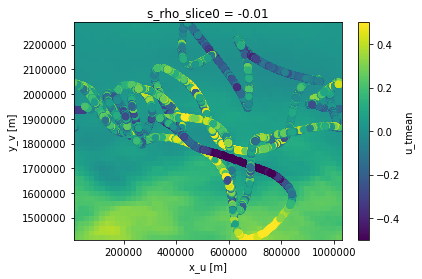

In [38]:
# Visu
eulerian_field.u_tmean.sel(x_rho=slice(df.x.min()*1e3,df.x.max()*1e3),y_rho=slice(df.y.min()*1e3,df.y.max()*1e3)).plot(vmin=-0.5,vmax=0.5,zorder=-1)
plt.scatter(df.x*1e3,df.y*1e3,c=df.u,vmin=-0.5,vmax=0.5)

In [8]:
mean_zon = eulerian_field.mean('x_rho')

In [106]:
uE = mean_zon.u_tmean.sel(y_rho=slice((df.y.min()-100)*1e3,(df.y.max()+100)*1e3))

number of points in y direction in eulerian field :  54
number of points in y direction along drifter trajectory :  71735


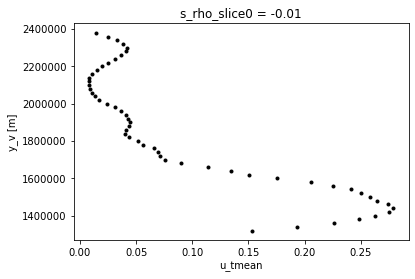

In [108]:
uE.plot.line('k.',y='y_rho')
print('number of points in y direction in eulerian field : ',uE.y_rho.size)
print('number of points in y direction along drifter trajectory : ',df.y.unique().size)

In [130]:
f = interpolate.interp1d(uE.y_rho,uE,kind='cubic')

In [107]:
print(uE.y_rho.max(),df.y.max()*1e3)

<xarray.DataArray 'y_rho' ()>
array(2380000., dtype=float32)
Coordinates:
    s_rho_slice0  float32 -0.01 2289850.52


In [131]:
uinterp = f(df.y*1e3)

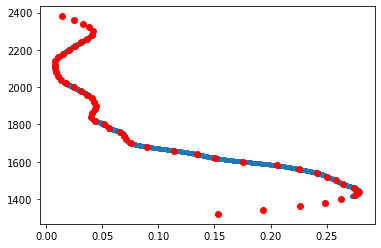

In [132]:
plt.plot(uinterp,df.y,'.')
plt.plot(uE,uE.y_rho*1e-3,'ro')

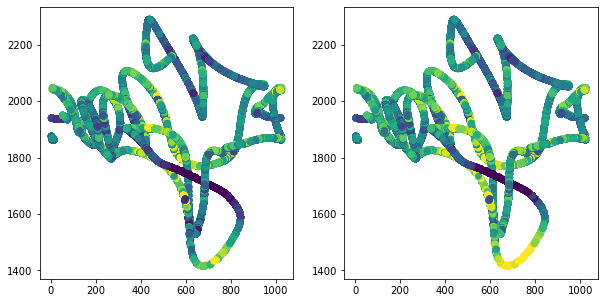

In [124]:
fig,ax = plt.subplots(1,2,figsize=(10,5))
ax[0].scatter(df.x,df.y,c=(df.u-uinterp),vmin=-0.5,vmax=0.5)
ax[1].scatter(df.x,df.y,c=df.u,vmin=-0.5,vmax=0.5)

### Over all drifters:

In [9]:
def interpolate_avg(ds,field,columns,dimension='1d'):
    """Interpolate the eulrian fied on the drifter trajectory.
    Parameters
    ----------
        ds : Pandas dataset
            Dataset of the drifter position
        field: xarray dataset
               Dataset oft he mean eulerian field to interpolate over the drifter trajectory
        columns: list of str 
            The variables we need to be interpolated (generally u and v)
        dimension: str ('1d' or '2d')
            Dimension of the innterpolation (either use the 2d field or the 1d field)
    
    Returns
    ----------
    ds : Dataset
         The time series along the drfiter trajectory with the averaged field substracted
    """
    if dimension=='1d':
        avg = field.mean('x_rho').interp(y_rho=ds.y*1e3).get(columns)
    if dimension=='2d':
        x = xr.Datarray(ds.x.values,dims='pos')
        y = xr.Datarray(ds.y.values,dims='pos')
        avg = field.interp(x_rho=x*1e3,y_rho=y*1e3).get(columns)
        #out = avg.get(columns)#.to_dataframe().drop(columns=['f','s_rho_slice0','f_rho'])
    for var in columns:
        ds[var] = ds[var]-avg[var]
    return ds

In [10]:
E_field = eulerian_field.rename({'u_mean':'u','v_mean':'v'})

In [16]:
print(df.u-E_field.mean('x_rho').interp(y_rho=df.y*1e3).u)
print(df.u)

id
225   -0.011964
225   -0.017582
225    0.273156
225    0.177909
225    0.174922
         ...   
225   -0.065201
225    0.561622
225    0.114852
225    0.059482
225    0.092692
Name: u, Length: 72004, dtype: float64
id
225    0.028135
225    0.022532
225    0.286140
225    0.218889
225    0.188402
         ...   
225   -0.056717
225    0.839395
225    0.125162
225    0.068251
225    0.120743
Name: u, Length: 72004, dtype: float64


In [24]:
#test
out = interpolate_E(df,E_field,['u','v'])#.rename(columns={'u_tmean':'u','v_tmean':'v'})

#### Apply interpolation and remove mean eulerian field from drifters trajectories (pre-processing)

In [11]:
DF = dr.df.groupby(dr.df.index).apply(interpolate_avg,E_field,['u','v']).persist()
DF

/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: `meta` is not specified, inferred from partial data. Please provide `meta` if the result is unexpected.
  Before: .apply(func)
  After:  .apply(func, meta={'x': 'f8', 'y': 'f8'}) for dataframe result
  or:     .apply(func, meta=('x', 'f8'))            for series result
  """Entry point for launching an IPython kernel.


,time,xgrid,ygrid,zgrid,depth,temp,u,v,dudt,dvdt,pres,x,y
npartitions=858,,,,,,,,,,,,,
,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...


In [12]:
# Wrapping function to apply the correlation to each drifter
def wrap_correlate(DS,columns,T,dt,L,binsize,detrend=True):
#df_chunked = dr.df.groupby(['id']).apply(chunk_processing, 10., .5)
    df_chunked = DS.groupby(DS.index).apply(cdr.time_window_processing,
                                            cdr.correlate, columns, T, int(T/dt/2),L, detrend=detrend,dt=dt
                                           ).persist()
                                         #   meta=('x', 'f8'))
    # the dataframe partitions has a multi-index: id and window central time (unknow name for now)
    # we first transform the index corresponding to time into a regular column.
    df_chunked = (
                  df_chunked.map_partitions(
                      lambda df: df.reset_index(level=[1]).rename(columns={'level_1': 'time'})
                                           )
                  )
    # bin along y and sum
    y_bins = np.arange(0,2800,binsize)
    y_idx = pd.IntervalIndex.from_breaks(y_bins)
    df_chunked['y_cut'] = df_chunked['y'].map_partitions(pd.cut, bins=y_bins)
    return df_chunked

In [13]:
# inputs: time window and step
T = 40 # days
dt = 10./60./24. # days, hack required because dt fluctuates by a bit !!
binsize = 50 # binsize over which we will average the correlation function
L = 1024 # size of the domain in the x driection (periodicity)

In [13]:
#DF = DF.repartition(npartitions=50).persist()

In [15]:
# Autocorrelation of u
df_chunked = wrap_correlate(DF,['u','u'],T,dt,L,binsize,detrend=False)
df_chunked

/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: `meta` is not specified, inferred from partial data. Please provide `meta` if the result is unexpected.
  Before: .apply(func)
  After:  .apply(func, meta={'x': 'f8', 'y': 'f8'}) for dataframe result
  or:     .apply(func, meta=('x', 'f8'))            for series result
  """


Dask DataFrame Structure:
                  time        x        y       id      0.0 0.006944444444444444 0.013888888888888888 0.020833333333333332 0.027777777777777776 0.034722222222222224 0.041666666666666664 0.048611111111111105 0.05555555555555555   0.0625 0.06944444444444445 0.07638888888888888 0.08333333333333333 0.09027777777777778 0.09722222222222221 0.10416666666666666 0.1111111111111111 0.11805555555555555    0.125 0.13194444444444445 0.1388888888888889 0.14583333333333331 0.15277777777777776 0.1597222222222222 0.16666666666666666 0.1736111111111111 0.18055555555555555   0.1875 0.19444444444444442 0.20138888888888887 0.20833333333333331 0.21527777777777776 0.2222222222222222 0.22916666666666666 0.2361111111111111 0.24305555555555555     0.25 0.2569444444444444 0.2638888888888889 0.2708333333333333 0.2777777777777778 0.2847222222222222 0.29166666666666663 0.2986111111111111 0.3055555555555555   0.3125 0.3194444444444444 0.3263888888888889 0.3333333333333333 0.34027777777777773 0.3472222222222222 0.35416666666666663 0.3611111111111111 0.3680555555555555    0.375 0.3819444444444444 0.38888888888888884 0.3958333333333333 0.40277777777777773 0.4097222222222222 0.41666666666666663 0.4236111111111111 0.4305555555555555   0.4375 0.4444444444444444 0.45138888888888884 0.4583333333333333 0.46527777777777773 0.4722222222222222 0.47916666666666663 0.4861111111111111 0.4930555555555555      0.5 0.5069444444444444 0.5138888888888888 0.5208333333333333 0.5277777777777778 0.5347222222222222 0.5416666666666666 0.548611111111111 0.5555555555555556   0.5625 0.5694444444444444 0.5763888888888888 0.5833333333333333 0.5902777777777778 0.5972222222222222 0.6041666666666666 0.611111111111111 0.6180555555555555    0.625 0.6319444444444444 0.6388888888888888 0.6458333333333333 0.6527777777777778 0.6597222222222222 0.6666666666666666 0.673611111111111 0.6805555555555555   0.6875 0.6944444444444444 0.7013888888888888 0.7083333333333333 0.7152777777777778 0.7222222222222222 0.7291666666666666 0.736111111111111 0.7430555555555555     0.75 0.7569444444444444 0.7638888888888888 0.7708333333333333 0.7777777777777777 0.7847222222222222 0.7916666666666666 0.798611111111111 0.8055555555555555   0.8125 0.8194444444444444 0.8263888888888888 0.8333333333333333 0.8402777777777777 0.8472222222222222 0.8541666666666666 0.861111111111111 0.8680555555555555    0.875 0.8819444444444444 0.8888888888888888 0.8958333333333333 0.9027777777777777 0.9097222222222222 0.9166666666666666 0.923611111111111 0.9305555555555555   0.9375 0.9444444444444444 0.9513888888888888 0.9583333333333333 0.9652777777777777 0.9722222222222222 0.9791666666666666 0.986111111111111 0.9930555555555555      1.0 1.0069444444444444 1.0138888888888888 1.0208333333333333 1.0277777777777777 1.034722222222222 1.0416666666666665 1.0486111111111112 1.0555555555555556   1.0625 1.0694444444444444 1.0763888888888888 1.0833333333333333 1.0902777777777777 1.097222222222222 1.1041666666666665 1.1111111111111112 1.1180555555555556    1.125 1.1319444444444444 1.1388888888888888 1.1458333333333333 1.1527777777777777 1.159722222222222 1.1666666666666665 1.173611111111111 1.1805555555555556   1.1875 1.1944444444444444 1.2013888888888888 1.2083333333333333 1.2152777777777777 1.222222222222222 1.2291666666666665 1.236111111111111 1.2430555555555556     1.25 1.2569444444444444 1.2638888888888888 1.2708333333333333 1.2777777777777777 1.284722222222222 1.2916666666666665 1.298611111111111 1.3055555555555556   1.3125 1.3194444444444444 1.3263888888888888 1.3333333333333333 1.3402777777777777 1.347222222222222 1.3541666666666665 1.361111111111111 1.3680555555555556    1.375 1.3819444444444444 1.3888888888888888 1.3958333333333333 1.4027777777777777 1.409722222222222 1.4166666666666665 1.423611111111111 1.4305555555555556   1.4375 1.4444444444444444 1.4513888888888888 1.4583333333333333 1.4652777777777777 1.472222222222222 1.4791666666666665 1.486111111111111 1.4930555555555556      1.5 1.5069444444444444 1.5138888888

In [16]:
# Binning and averaging
uu = df_chunked.groupby(['y_cut']).mean().compute()
#Converting pandas dataframe in xarray dataset:
ds = (pd.melt(uu.set_index(uu.index.map(lambda v: v.mid))
              .drop(columns=['id','time','x','y'])
              .reset_index(), id_vars=['y_cut'], var_name='lag')
              .rename(columns={'y_cut': 'y_bins', 'value': 'uu'})).to_xarray().set_index(index=['y_bins','lag']).unstack()

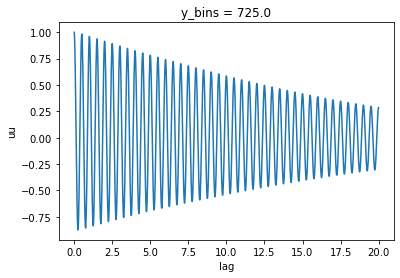

In [17]:
(ds.uu/ds.uu.sel(lag=0)).sel(y_bins=700,method='nearest').plot()

In [18]:
# Autocorrelation of v
df_chunked = wrap_correlate(DF,['v','v'],T,dt,L,binsize,detrend=False)
#df_chunked = df_chunked.repartition(npartitions=30).persist()

/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: `meta` is not specified, inferred from partial data. Please provide `meta` if the result is unexpected.
  Before: .apply(func)
  After:  .apply(func, meta={'x': 'f8', 'y': 'f8'}) for dataframe result
  or:     .apply(func, meta=('x', 'f8'))            for series result
  """


In [19]:
vv = df_chunked.groupby(['y_cut']).mean().compute()
#Converting pandas dataframe in xarray dataset:
ds['vv'] = (pd.melt(vv.set_index(vv.index.map(lambda v: v.mid))
                    .drop(columns=['id','time','x','y'])
                    .reset_index(), id_vars=['y_cut'], var_name='lag')
                    .rename(columns={'y_cut': 'y_bins', 'value': 'vv'})).to_xarray().set_index(index=['y_bins','lag']).unstack().vv

In [20]:
#Crosscorrelation uv
df_chunked = wrap_correlate(DF,['u','v'],T,dt,L,binsize,detrend=False)
#df_chunked = df_chunked.repartition(npartitions=30).persist()

/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: `meta` is not specified, inferred from partial data. Please provide `meta` if the result is unexpected.
  Before: .apply(func)
  After:  .apply(func, meta={'x': 'f8', 'y': 'f8'}) for dataframe result
  or:     .apply(func, meta=('x', 'f8'))            for series result
  """


In [21]:
uv = df_chunked.groupby(['y_cut']).mean().compute()
#Converting pandas dataframe in xarray dataset:
ds['uv'] = (pd.melt(uv.set_index(uv.index.map(lambda v: v.mid))
              .drop(columns=['id','time','x','y'])
              .reset_index(), id_vars=['y_cut'], var_name='lag')
              .rename(columns={'y_cut': 'y_bins', 'value': 'uv'})).to_xarray().set_index(index=['y_bins','lag']).unstack().uv

In [22]:
#Crosscorrelation uv
df_chunked = wrap_correlate(DF,['v','u'],T,dt,L,binsize,detrend=False)

/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: `meta` is not specified, inferred from partial data. Please provide `meta` if the result is unexpected.
  Before: .apply(func)
  After:  .apply(func, meta={'x': 'f8', 'y': 'f8'}) for dataframe result
  or:     .apply(func, meta=('x', 'f8'))            for series result
  """


In [23]:
vu = df_chunked.groupby(['y_cut']).mean().compute()
#Converting pandas dataframe in xarray dataset:
ds['vu'] = (pd.melt(vu.set_index(vu.index.map(lambda v: v.mid))
              .drop(columns=['id','time','x','y'])
              .reset_index(), id_vars=['y_cut'], var_name='lag')
              .rename(columns={'y_cut': 'y_bins', 'value': 'vu'})).to_xarray().set_index(index=['y_bins','lag']).unstack().vu

In [24]:
ds

<xarray.Dataset>
Dimensions:  (lag: 2880, y_bins: 55)
Coordinates:
  * y_bins   (y_bins) float64 25.0 75.0 125.0 ... 2.625e+03 2.675e+03 2.725e+03
  * lag      (lag) float64 0.0 0.006944 0.01389 0.02083 ... 19.98 19.99 19.99
Data variables:
    uu       (y_bins, lag) float64 nan nan nan nan nan ... nan nan nan nan nan
    vv       (y_bins, lag) float64 nan nan nan nan nan ... nan nan nan nan nan
    uv       (y_bins, lag) float64 nan nan nan nan nan ... nan nan nan nan nan
    vu       (y_bins, lag) float64 nan nan nan nan nan ... nan nan nan nan nan

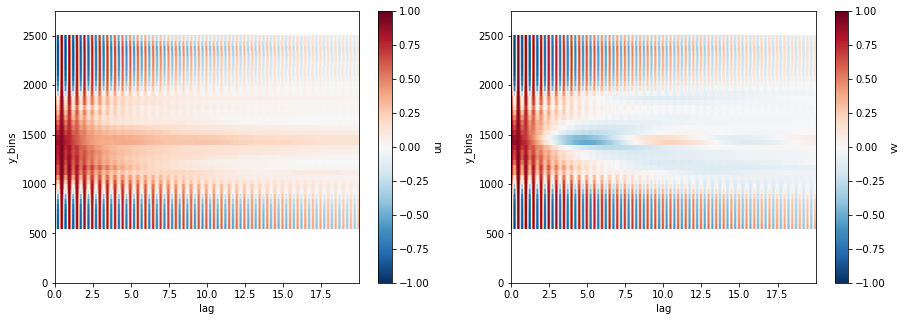

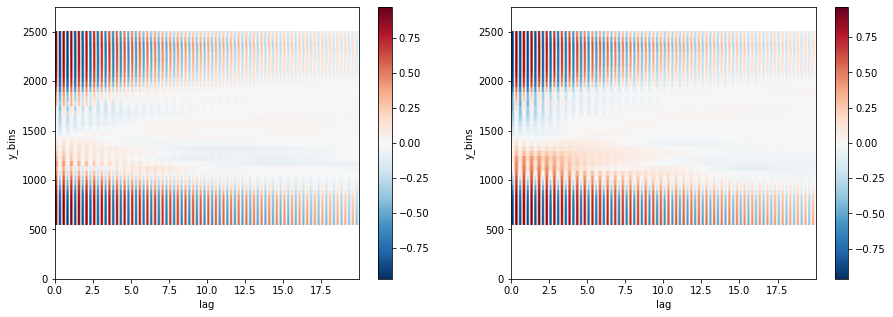

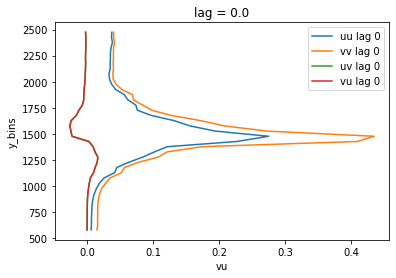

In [25]:
#Visualization 2d : Normalized autocorrelation
fig,axs=plt.subplots(1,2,figsize=(15,5))
for V,ax in zip(['uu','vv'],axs):
    (ds[V]/ds[V].sel(lag=0.)).plot(ax=ax)
fig,axs=plt.subplots(1,2,figsize=(15,5))
for V,ax in zip(['uv','vu'],axs):#
    (ds[V]/np.sqrt(ds['uu'].sel(lag=0.)*ds['vv'].sel(lag=0.))).plot(ax=ax)

plt.figure()
for V in ['uu','vv','uv','vu']:#,'vu'
    ds[V].sel(lag=0).plot(y='y_bins',label='%s lag 0'%V)
plt.legend()

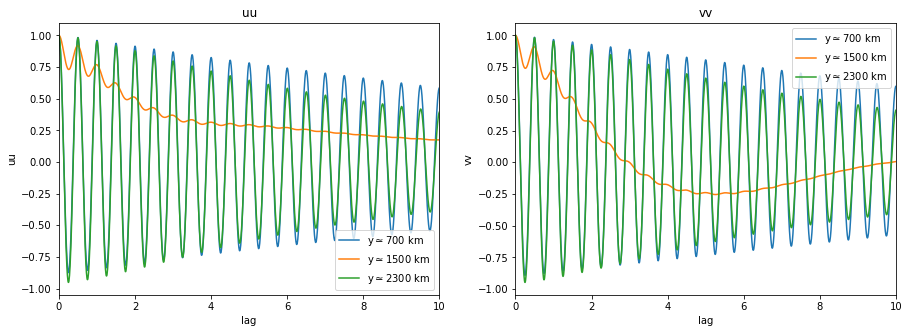

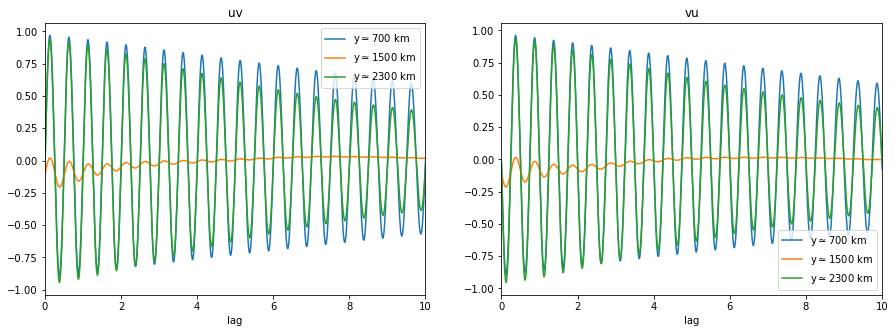

In [26]:
# Normalized correlations for 3 y (center of the bin) 
Y = [700,1500,2300]
fig,axs=plt.subplots(1,2,figsize=(15,5))
for y in Y:
    for V,ax in zip(['uu','vv'],axs):
        (ds[V]/ds[V].sel(lag=0.)).sel(y_bins=y,method='nearest').plot(ax=ax,label=r'y$\simeq$%s km'%y)
        ax.legend();ax.set_title(V);ax.set_xlim(0,10)
fig,axs=plt.subplots(1,2,figsize=(15,5))
for y in Y:
    for V,ax in zip(['uv','vu'],axs):#,'vu'
        (ds[V]/np.sqrt(ds['uu'].sel(lag=0.)*ds['vv'].sel(lag=0.))).sel(y_bins=y,method='nearest').plot(ax=ax,label=r'y$\simeq$%s km'%y
                                                                                                      )
        ax.legend();ax.set_title(V);ax.set_xlim(0,10)

#### Definition of attributes and storage of the results
The name of the nc files are name of the user_ouptuts used (drifters or eulerian)_corr_time window size&code\
The code used after the time window size is d if detrended data, avg1d or avg2d for average (1d or 2d) removed, total if nothing is removed. The removed part of signal are to be indicated in the attributes of the dataset ds.

In [27]:
attrs = {'Window' : T, 'Overlap' : 0.5, 'Bins_size' : binsize, 'Fourier window' : 'hann', 'removed':'avg1d'}

In [28]:
ds.attrs=attrs

In [29]:
ds

<xarray.Dataset>
Dimensions:  (lag: 2880, y_bins: 55)
Coordinates:
  * y_bins   (y_bins) float64 25.0 75.0 125.0 ... 2.625e+03 2.675e+03 2.725e+03
  * lag      (lag) float64 0.0 0.006944 0.01389 0.02083 ... 19.98 19.99 19.99
Data variables:
    uu       (y_bins, lag) float64 nan nan nan nan nan ... nan nan nan nan nan
    vv       (y_bins, lag) float64 nan nan nan nan nan ... nan nan nan nan nan
    uv       (y_bins, lag) float64 nan nan nan nan nan ... nan nan nan nan nan
    vu       (y_bins, lag) float64 nan nan nan nan nan ... nan nan nan nan nan
Attributes:
    Window:          40
    Overlap:         0.5
    Bins_size:       50
    Fourier window:  hann
    removed:         avg1d

In [30]:
r = pp.Run(root_path+run, prefix='', outputs=['surf','his'], verbose=False)

In [31]:
r.store_diagnostic('ZC_drifters_corr_40avg1d', ds, overwrite=True,file_format='netcdf')

data stored in /home/datawork-lops-osi/equinox/jetn/jet_cfg1_wp8_m1a1_4km_500a1000j/diagnostics/ZC_drifters_corr_40avg1d.nc


In [32]:
cluster.close()

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
concurrent.futures._base.CancelledError
